## Pré-processamento

In [1]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import string
from sklearn.model_selection import train_test_split
#import spacy

df = pd.read_csv('factnews_dataset.csv')

#criar grupo treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

stop_words = set(stopwords.words('portuguese'))

#criar coluna tokens
train_df['tokens'] = train_df['sentences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))

# Tokenizar sem stopwords
train_df['tokens_no_stopwords'] = train_df['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words])

## Análise exploratória

In [2]:
# Contar número de linhas por classe
contagem_classes = train_df['classe'].value_counts()
print(contagem_classes)


classe
 0    3394
-1    1115
 1     443
Name: count, dtype: int64


Detetar palavras únicas entre as classes

In [3]:
classes = df['classe'].unique()

def palavras_unicas_por_classe(df, token_col):
    
    # contar tokens por classe
    tokens_por_classe = {}
    for classe in classes:
        linhas_classe = df[df['classe'] == classe][token_col].dropna()
        contagem = {}
        for lista in linhas_classe:
            for token in lista:
                if token in contagem:
                    contagem[token] += 1
                else:
                    contagem[token] = 1
        tokens_por_classe[classe] = contagem

    # detetar palavras exclusivas por classe
    palavras_unicas = {}
    for classe in classes:
        # lista de palavras das outras classes
        outras_palavras = []
        for outra_classe in classes:
            if outra_classe != classe:
                for token in tokens_por_classe[outra_classe]:
                    outras_palavras.append(token)

        # dicionário palavras exclusivas com contagens
        unicas_classe = {}
        for palavra, contagem in tokens_por_classe[classe].items():
            exclusiva = True
            for p in outras_palavras:
                if p == palavra:
                    exclusiva = False
                    break
            if exclusiva:
                unicas_classe[palavra] = contagem

        palavras_unicas[classe] = unicas_classe

    return palavras_unicas

#palavras_unicas_por_classe(train_df,'tokens')


ver a proporção de advérbios e adjetivos entre as classes

In [ ]:
nltk.download('mac_morpho') 
from nltk.corpus import mac_morpho

dic_palavras = {}  # Dic para palavras de cada classe gramatical
for palavra, tag in mac_morpho.tagged_words():  # (palavra, tag)
    if tag not in dic_palavras: 
        dic_palavras[tag] = set()
    dic_palavras[tag].add(palavra.lower())  # associar palavra à respetiva tag

print (dic_palavras)

[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\furdu\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


ValueError: concat() expects at least one object!

In [14]:
def proporcao_adverbios_adjetivos_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()  
    proporcoes_por_classe = {}     

    lista_adverbios = dic_palavras.get('ADV', set())  
    lista_adjetivos = dic_palavras.get('ADJ', set())  

    
    for classe in classes: 
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()  
            
        total_adverbios_classe = 0   
        total_adjetivos_classe = 0    
        total_tokens_classe = 0
        # contar advérbios e adjetivos
        for lista_tokens in tokens_por_classe:
            total_adverbios_classe += sum(1 for token in lista_tokens if token in lista_adverbios)
            total_adjetivos_classe += sum(1 for token in lista_tokens if token in lista_adjetivos)
            total_tokens_classe += len(lista_tokens)

        proporcoes_por_classe[classe] = {
            'total_adverbios': total_adverbios_classe,
            'media_adverbios_por_token': total_adverbios_classe / total_tokens_classe,
            'total_adjetivos': total_adjetivos_classe,
            'media_adjetivos_por_token': total_adjetivos_classe / total_tokens_classe,
        }
    
    return proporcoes_por_classe

proporcao_adverbios_adjetivos_por_classe(train_df, 'tokens')

{np.int64(0): {'total_adverbios': 0,
  'media_adverbios_por_token': 0.0,
  'total_adjetivos': 0,
  'media_adjetivos_por_token': 0.0},
 np.int64(-1): {'total_adverbios': 0,
  'media_adverbios_por_token': 0.0,
  'total_adjetivos': 0,
  'media_adjetivos_por_token': 0.0},
 np.int64(1): {'total_adverbios': 0,
  'media_adverbios_por_token': 0.0,
  'total_adjetivos': 0,
  'media_adjetivos_por_token': 0.0}}

## Contruir regras para classificar o texto

Regras para a classe -1 (citação)

In [5]:
def citacao(text):
    return '"' in str(text) or '“' in str(text) or '”' in str(text) or '[' in str(text) 

Regras para a classe 0 (facto)

Regras para a classe 1 (viés)

In [6]:
def bias(text):
    return '?' in str(text)

In [7]:
def classificar(row):
    if citacao(row['sentences']):
        return -1  
    if bias(row['sentences']):
        return 1
    return 0

In [8]:
def classificar_texto(row):
    texto = row['sentences'].lower()

    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }
    #citacao
    if '"' in texto or '“' in texto or '”' in texto or "'" in texto or "’" in texto:
        pontos['citacao'] += 2
    if any(verbo in texto for verbo in ['disse', 'afirmou', 'relatou', 'segundo', 'comentou']):
        pontos['citacao'] += 1
        

    #bias
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estaram', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    # Escolher categoria com maior pontuação
    classe_max = max(pontos, key=pontos.get)
    
    # Mapear para classes Numéricas
    mapa_classes = {
        'citacao': -1,
        'facto': 0,
        'bias': 1,
    }
    
    return mapa_classes[classe_max]


ver verbo verbo numa frase - prob um bias

## Aplicar classificação no conjunto de teste

In [9]:
test_df['Previsto'] = test_df.apply(classificar, axis=1)
test_df['Previsto2'] = test_df.apply(classificar_texto, axis=1)


## Avaliar as regras de classificação

In [10]:
print(test_df[['sentences', 'classe', 'Previsto', 'Previsto2']].head())

                                              sentences  classe  Previsto  \
996   No primeiro turno, o candidato da esquerda chi...       0         0   
468   Esta é a segunda vez em menos de um ano que o ...       0         0   
6077  A margem de erro é dois pontos para mais ou pa...       0         0   
2127  Passei um dia na cidade nesta semana -moro no ...      -1         0   
2080  Na ocasião, o peemedebista discordou dos outro...       0         0   

      Previsto2  
996          -1  
468           0  
6077         -1  
2127         -1  
2080         -1  


Certos: 969 de 6191
Accuracy: 15.65%
Classe -1:  65.21739130434783 %
Classe 0:  92.9245283018868 %
Classe 1:  0.8695652173913043 %


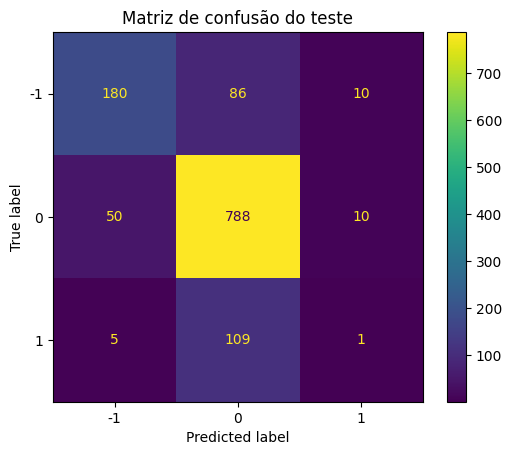

In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto']).sum()
total = len(df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

Certos: 485 de 6191
Accuracy: 7.83%
Classe -1:  93.11594202898551 %
Classe 0:  26.41509433962264 %
Classe 1:  3.4782608695652173 %


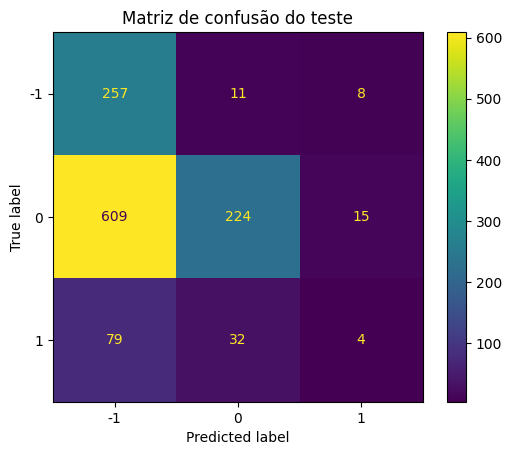

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto2']).sum()
total = len(df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto2']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto2'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()